# Making modeling scheme validation figures using 3 taxa

* Taxa differing in G+C content
  * low GC = 
  * mid GC = E. coli
  * high GC = 

### Genomic fragment simulation

* Sup Figure:
  * 3 taxa of differing GC
  * Fragment length distributions
    * 'realistic' = skewed normal
    * 'large' = ~50 kb
    * 'small' = ~1-2 kb
  * faceted heatmap:
    * taxa ~ (fragment length distribution)

### Diffusion calculations

* Sup Figure:
  * 3 taxa of differing GC (same as last)
  * histograms:
    * BD distribution for pre & post diffusion 
  * Shows effect of diffusion & how it relates to fragment length


# Setting variables

In [1]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome3/validation/'
genomeDir = '/home/nick/notebook/SIPSim/dev/bac_genome3/genomes/'
R_dir = '/home/nick/notebook/SIPSim/lib/R/'
figDir = '/home/nick/notebook/SIPSim/figures/'

# Init

In [82]:
import os
import glob
import nestly
from IPython.display import Image
import dill
import numpy as np                                                              
import pandas as pd                                                             
import scipy.stats as stats

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library(ggplot2)
library(plyr)
library(dplyr)
library(tidyr)
library(gridExtra)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [7]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)

# Simulating fragments

  * Fragment length distributions
    * 'realistic' = skewed normal
    * 'large' = ~50 kb
    * 'small' = ~1-2 kb

In [174]:
!cd $workDir; \
    SIPSim fragments \
    $genomeDir/genome_index.txt \
    --fp $genomeDir \
    --fr ../../515F-806R.fna \
    --fld skewed-normal,9000,2500,-5 \
    --flr None,None \
    --nf 10000 \
    --np 24 \
    --tbl \
    2> ampFrags_real.log \
    > ampFrags_real.txt       

In [175]:
!cd $workDir; \
    SIPSim fragments \
    $genomeDir/genome_index.txt \
    --fp $genomeDir \
    --fr ../../515F-806R.fna \
    --fld uniform,1000,2000 \
    --flr None,None \
    --nf 10000 \
    --np 24 \
    --tbl \
    2> ampFrags_sm.log \
    > ampFrags_sm.txt       

In [176]:
!cd $workDir; \
    SIPSim fragments \
    $genomeDir/genome_index.txt \
    --fp $genomeDir \
    --fr ../../515F-806R.fna \
    --fld uniform,50000,51000 \
    --flr None,None \
    --nf 10000 \
    --np 24 \
    --tbl \
    2> ampFrags_lg.log \
    > ampFrags_lg.txt       

## Plotting fragments

In [8]:
%%R -i workDir
setwd(workDir)

files = c('ampFrags_real.txt',
          'ampFrags_sm.txt',
          'ampFrags_lg.txt')

tbl.l = list()
for(f in files){
    tbl.l[[f]] = read.delim(f, sep='\t')
    }
tbl = do.call(rbind, tbl.l)
tbl %>% head(n=3)

                                           taxon_name
ampFrags_real.txt.1 Clostridium_ljungdahlii_DSM_13528
ampFrags_real.txt.2 Clostridium_ljungdahlii_DSM_13528
ampFrags_real.txt.3 Clostridium_ljungdahlii_DSM_13528
                                                    scaffoldID fragStart
ampFrags_real.txt.1 CP001666_Clostridium_ljungdahlii_DSM_13528   1479222
ampFrags_real.txt.2 CP001666_Clostridium_ljungdahlii_DSM_13528   2672877
ampFrags_real.txt.3 CP001666_Clostridium_ljungdahlii_DSM_13528   2743558
                    fragLength   fragGC
ampFrags_real.txt.1       6148 29.50553
ampFrags_real.txt.2       8966 33.14745
ampFrags_real.txt.3       7589 30.95269


In [9]:
%%R
tbl$fld = gsub('\\.txt.+', '', rownames(tbl))
tbl %>% head(n=3)

                                           taxon_name
ampFrags_real.txt.1 Clostridium_ljungdahlii_DSM_13528
ampFrags_real.txt.2 Clostridium_ljungdahlii_DSM_13528
ampFrags_real.txt.3 Clostridium_ljungdahlii_DSM_13528
                                                    scaffoldID fragStart
ampFrags_real.txt.1 CP001666_Clostridium_ljungdahlii_DSM_13528   1479222
ampFrags_real.txt.2 CP001666_Clostridium_ljungdahlii_DSM_13528   2672877
ampFrags_real.txt.3 CP001666_Clostridium_ljungdahlii_DSM_13528   2743558
                    fragLength   fragGC           fld
ampFrags_real.txt.1       6148 29.50553 ampFrags_real
ampFrags_real.txt.2       8966 33.14745 ampFrags_real
ampFrags_real.txt.3       7589 30.95269 ampFrags_real


In [10]:
%%R 

fld.revalue = c('ampFrags_real' = 'skewed normal (mean = 9 kb)',
                  'ampFrags_sm' = 'uniform (1-2 kb)',
                  'ampFrags_lg' = 'uniform (50-51 kb)')

taxon.revalue = c('Clostridium_ljungdahlii_DSM_13528' = 'Clostridium_ljungdahlii\nDSM_13528',
                  'Streptomyces_pratensis_ATCC_33331' = 'Streptomyces_pratensis\nATCC_33331')


tbl.f = tbl %>%
    mutate(taxon_name = revalue(taxon_name, taxon.revalue),
           fld = revalue(fld, fld.revalue)) %>%
    mutate(taxon_name = gsub('_', ' ', taxon_name))

tbl.f %>% head(n=3)

                          taxon_name                                 scaffoldID
1 Clostridium ljungdahlii\nDSM 13528 CP001666_Clostridium_ljungdahlii_DSM_13528
2 Clostridium ljungdahlii\nDSM 13528 CP001666_Clostridium_ljungdahlii_DSM_13528
3 Clostridium ljungdahlii\nDSM 13528 CP001666_Clostridium_ljungdahlii_DSM_13528
  fragStart fragLength   fragGC                         fld
1   1479222       6148 29.50553 skewed normal (mean = 9 kb)
2   2672877       8966 33.14745 skewed normal (mean = 9 kb)
3   2743558       7589 30.95269 skewed normal (mean = 9 kb)


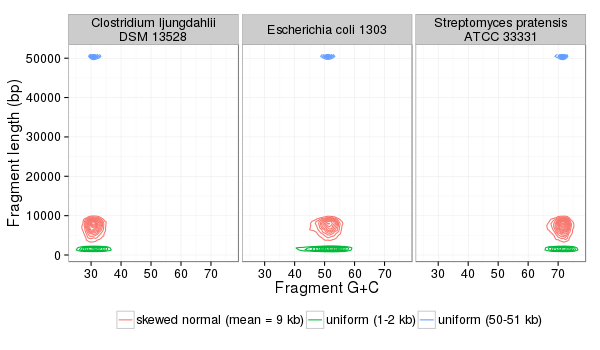

In [15]:
%%R -w 600 -h 350

ggplot(tbl.f, aes(fragGC, fragLength, color=fld)) +
    stat_density2d() +
    scale_color_discrete(name='') +
    labs(x='Fragment G+C', y='Fragment length (bp)') +
    facet_grid(. ~ taxon_name) +
    theme_bw() +
    theme(
        text=element_text(size=16),
        axis.title.y=element_text(vjust=1),
        legend.position = 'bottom'
        )

In [16]:
%%R -i figDir

outFile = paste(c(figDir, 'genome3_fragKDE.pdf'), collapse='/')
ggsave(outFile, width=10, height=4)

# Converting to KDE

In [182]:
!cd $workDir; \
    SIPSim fragment_kde \
    ampFrags_real.txt \
    > ampFrags_real_kde.pkl
    
!cd $workDir; \
    SIPSim fragment_kde \
    ampFrags_sm.txt \
    > ampFrags_sm_kde.pkl
    
!cd $workDir; \
    SIPSim fragment_kde \
    ampFrags_lg.txt \
    > ampFrags_lg_kde.pkl    

# Adding diffusion

In [183]:
!cd $workDir; \
    SIPSim diffusion \
    ampFrags_real_kde.pkl \
    --np 24 \
    > ampFrags_real_kde_dif.pkl    
    
!cd $workDir; \
    SIPSim diffusion \
    ampFrags_sm_kde.pkl \
    --np 24 \
    > ampFrags_sm_kde_dif.pkl    
    
!cd $workDir; \
    SIPSim diffusion \
    ampFrags_lg_kde.pkl \
    --np 24 \
    > ampFrags_lg_kde_dif.pkl        

Processing: Clostridium_ljungdahlii_DSM_13528
Processing: Streptomyces_pratensis_ATCC_33331
Processing: Escherichia_coli_1303
Processing: Clostridium_ljungdahlii_DSM_13528
Processing: Streptomyces_pratensis_ATCC_33331
Processing: Escherichia_coli_1303
Processing: Clostridium_ljungdahlii_DSM_13528
Processing: Streptomyces_pratensis_ATCC_33331
Processing: Escherichia_coli_1303


# Plotting fragment distribution w/ and w/out diffusion

## Making a table of fragment values from KDEs

In [184]:
%%bash -s "$workDir"

n=100000

SIPSim KDE_sample -n $n ampFrags_real_kde.pkl > ampFrags_real_kde.txt
SIPSim KDE_sample -n $n ampFrags_real_kde_dif.pkl > ampFrags_real_kde_dif.txt

SIPSim KDE_sample -n $n ampFrags_sm_kde.pkl > ampFrags_sm_kde.txt
SIPSim KDE_sample -n $n ampFrags_sm_kde_dif.pkl > ampFrags_sm_kde_dif.txt

SIPSim KDE_sample -n $n ampFrags_lg_kde.pkl > ampFrags_lg_kde.txt
SIPSim KDE_sample -n $n ampFrags_lg_kde_dif.pkl > ampFrags_lg_kde_dif.txt

## Plotting

In [17]:
%%R -i workDir

kde.files = c('ampFrags_real_kde.txt',
              'ampFrags_sm_kde.txt',
              'ampFrags_lg_kde.txt')
kde.dif.files = c('ampFrags_real_kde_dif.txt',
                  'ampFrags_sm_kde_dif.txt',
                  'ampFrags_lg_kde_dif.txt')


load.tables = function(files, data.id){
    tbl.l = list()
    for(f in files){
        F = file.path(workDir, f)
        x = read.delim(F, sep='\t')
        x = mutate(x, 
                   data = data.id,
                   fld = gsub('_kde(_dif)*.txt', '', f))
        tbl.l[[f]] = x
        }
    
    tbl = do.call(rbind, tbl.l) %>%
        gather('taxon_name','BD', 2:4)
    return(tbl)
    }

tbl1 = load.tables(kde.files, 'no diffusion')
tbl2 = load.tables(kde.dif.files, 'diffusion')
tbl = rbind(tbl1, tbl2)
tbl %>% head(n=3)

  X         data           fld                        taxon_name       BD
1 0 no diffusion ampFrags_real Clostridium_ljungdahlii_DSM_13528 1.689012
2 1 no diffusion ampFrags_real Clostridium_ljungdahlii_DSM_13528 1.692213
3 2 no diffusion ampFrags_real Clostridium_ljungdahlii_DSM_13528 1.687114


In [18]:
%%R 

fld.revalue = c('ampFrags_real' = 'skewed normal\n(mean = 9 kb)',
                'ampFrags_sm' = 'uniform\n(1-2 kb)',
                'ampFrags_lg' = 'uniform\n(50-51 kb)')

taxon.revalue = c('Clostridium_ljungdahlii_DSM_13528' = 'Clostridium_ljungdahlii\nDSM_13528',
                  'Streptomyces_pratensis_ATCC_33331' = 'Streptomyces_pratensis\nATCC_33331')


tbl.f = tbl %>%
    mutate(taxon_name = revalue(taxon_name, taxon.revalue),
           fld = revalue(fld, fld.revalue)) %>%
    mutate(taxon_name = gsub('_', ' ', taxon_name))

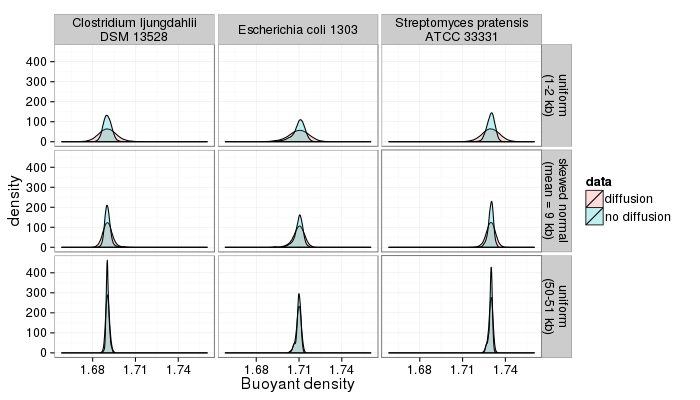

In [19]:
%%R -w 700 -h 400

tbl.f$fld = factor(tbl.f$fld, 
                   levels=c('uniform\n(1-2 kb)','skewed normal\n(mean = 9 kb)','uniform\n(50-51 kb)'))


ggplot(tbl.f, aes(BD, fill=data)) +
    geom_density(alpha=0.25) +
    facet_grid(fld ~ taxon_name) +
    theme_bw() +
    labs(x = 'Buoyant density') +
    theme(
        text=element_text(size=16),
        axis.title.y = element_text(vjust=1)
        )

In [20]:
%%R -i figDir 

outFile = paste(c(figDir, 'genome3_fragKDE_dif.pdf'), collapse='/')
ggsave(outFile, width=10, height=5.71) 

## Determining the probability of detecting the taxa across the entire gradient

* For real data, most taxa (>0.1% abundance) are detected across the entire gradient.
* This should provide an idea of how that matches the simulation

In [83]:
# max 13C shift
max_13C_shift_in_BD = 0.036
# min BD (that we care about)
min_GC = 13.5
min_BD = min_GC/100.0 * 0.098 + 1.66
# max BD (that we care about)
max_GC = 80
max_BD = max_GC / 100.0 * 0.098 + 1.66    # 80.0% G+C
max_BD = max_BD + max_13C_shift_in_BD
## BD range of values
BD_vals = np.arange(min_BD, max_BD, 0.001)

### skewed normal distribution

In [84]:
F = os.path.join(workDir, 'ampFrags_real_kde_dif.pkl')
with open(F, 'rb') as inFH:
    kde = dill.load(inFH)
kde

{'Clostridium_ljungdahlii_DSM_13528': <scipy.stats.kde.gaussian_kde at 0x7f226b254d10>,
 'Escherichia_coli_1303': <scipy.stats.kde.gaussian_kde at 0x7f226b254a10>,
 'Streptomyces_pratensis_ATCC_33331': <scipy.stats.kde.gaussian_kde at 0x7f226b254ad0>}

In [85]:
# probability at each location in gradient
pdf = {}
for k,v in kde.items():
    pdf[k] = v.evaluate(BD_vals)
pdf.keys()

['Clostridium_ljungdahlii_DSM_13528',
 'Escherichia_coli_1303',
 'Streptomyces_pratensis_ATCC_33331']

In [86]:
df = pd.DataFrame(pdf)
df['BD'] = BD_vals
df.head(n=3)

,Clostridium_ljungdahlii_DSM_13528,Escherichia_coli_1303,Streptomyces_pratensis_ATCC_33331,BD
0,0.014088,1.019445e-78,0,1.67323
1,0.036811,2.098006e-70,0,1.67423
2,0.052655,1.198137e-53,0,1.67523


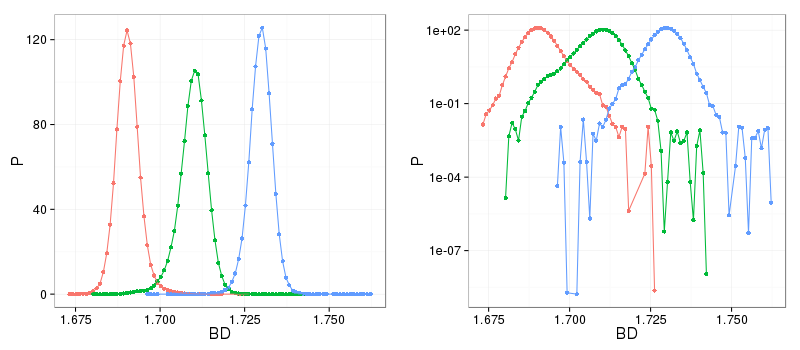

In [87]:
%%R -i df -w 800 -h 350

df.g = apply(df, 2, as.numeric) %>% as.data.frame %>%
    gather(taxon_name, P, 1:3) %>%
    mutate(BD = as.numeric(BD),
           P = as.numeric(P),
           taxon_name = as.character(taxon_name)) %>%
    filter(P > 1e-9)



p1 = ggplot(df.g, aes(BD, P, color=taxon_name)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'none'
    )

p2 = p1 + scale_y_log10()

grid.arrange(p1, p2, ncol=2)

In [110]:
# probability at each location in gradient
pdf = {}
for k,v in kde.items():
    pdf[k] = v.evaluate(BD_vals)
pdf.keys()

['Clostridium_ljungdahlii_DSM_13528',
 'Escherichia_coli_1303',
 'Streptomyces_pratensis_ATCC_33331']

In [111]:
df = pd.DataFrame(pdf)
df['BD'] = BD_vals
df.head(n=3)

,Clostridium_ljungdahlii_DSM_13528,Escherichia_coli_1303,Streptomyces_pratensis_ATCC_33331,BD
0,1.655999,0.003251,0.000000e+00,1.67323
1,2.186443,0.011197,0.000000e+00,1.67423
2,3.199720,0.012621,5.259635e-314,1.67523


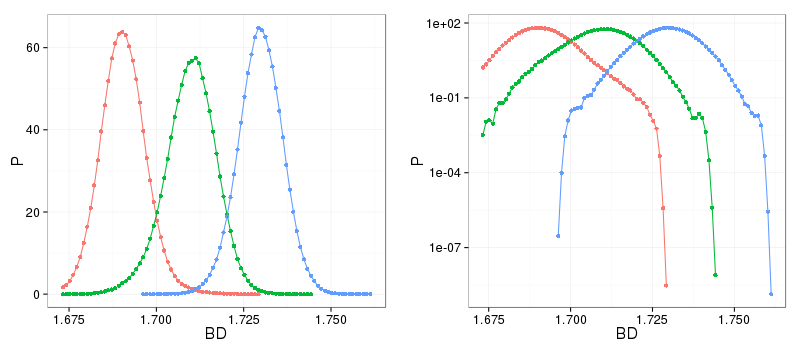

In [112]:
%%R -i df -w 800 -h 350

df.g = apply(df, 2, as.numeric) %>% as.data.frame %>%
    gather(taxon_name, P, 1:3) %>%
    mutate(BD = as.numeric(BD),
           P = as.numeric(P),
           taxon_name = as.character(taxon_name)) %>%
    filter(P > 1e-9)



p1 = ggplot(df.g, aes(BD, P, color=taxon_name)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'none'
    )

p2 = p1 + scale_y_log10()

grid.arrange(p1, p2, ncol=2)

### small uniform distribution

In [97]:
F = os.path.join(workDir, 'ampFrags_sm_kde_dif.pkl')
with open(F, 'rb') as inFH:
    kde = dill.load(inFH)
kde

{'Clostridium_ljungdahlii_DSM_13528': <scipy.stats.kde.gaussian_kde at 0x7ff0f0a43610>,
 'Escherichia_coli_1303': <scipy.stats.kde.gaussian_kde at 0x7ff0f083c150>,
 'Streptomyces_pratensis_ATCC_33331': <scipy.stats.kde.gaussian_kde at 0x7ff0f083c290>}

In [98]:
# probability at each location in gradient
pdf = {}
for k,v in kde.items():
    pdf[k] = v.evaluate(BD_vals)
pdf.keys()

['Clostridium_ljungdahlii_DSM_13528',
 'Escherichia_coli_1303',
 'Streptomyces_pratensis_ATCC_33331']

In [99]:
df = pd.DataFrame(pdf)
df['BD'] = BD_vals
df.head(n=3)

,Clostridium_ljungdahlii_DSM_13528,Escherichia_coli_1303,Streptomyces_pratensis_ATCC_33331,BD
0,1.655999,0.003251,0.000000e+00,1.67323
1,2.186443,0.011197,0.000000e+00,1.67423
2,3.199720,0.012621,5.259635e-314,1.67523


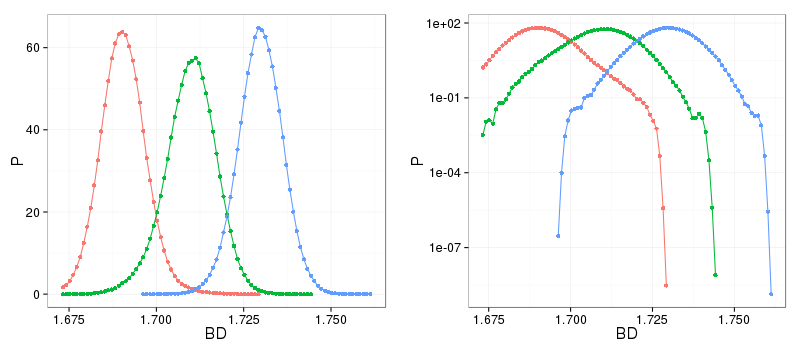

In [100]:
%%R -i df -w 800 -h 350

df.g = apply(df, 2, as.numeric) %>% as.data.frame %>%
    gather(taxon_name, P, 1:3) %>%
    mutate(BD = as.numeric(BD),
           P = as.numeric(P),
           taxon_name = as.character(taxon_name)) %>%
    filter(P > 1e-9)



p1 = ggplot(df.g, aes(BD, P, color=taxon_name)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'none'
    )

p2 = p1 + scale_y_log10()

grid.arrange(p1, p2, ncol=2)

#### Notes

* Even with fragment sizes of 1-2 kb, the taxa would likely not be detected even if the gradient contained 1e9 16S copies of the taxon.
  * Does this make sense based on the theory of diffusion used?

# Adding DBL 'smearing' to diffusion KDEs

In [147]:
# fraction of fragments in DBL
frac_abs = 0.01
procs = 3

!cd $workDir; \
    SIPSim DBL \
    ampFrags_real_kde_dif.pkl \
    --frac_abs $frac_abs \
    --np $procs \
    > ampFrags_real_kde_dif_DBL.pkl    
    
!cd $workDir; \
    SIPSim DBL \
    ampFrags_sm_kde_dif.pkl \
    --frac_abs $frac_abs \
    --np $procs \
    > ampFrags_sm_kde_dif_DBL.pkl    
    
!cd $workDir; \
    SIPSim DBL \
    ampFrags_lg_kde_dif.pkl \
    --frac_abs $frac_abs \
    --np $procs \
    > ampFrags_lg_kde_dif_DBL.pkl        

DBL_index file written: "DBL_index.txt"
Processing: Clostridium_ljungdahlii_DSM_13528
Processing: Streptomyces_pratensis_ATCC_33331
Processing: Escherichia_coli_1303
DBL_index file written: "DBL_index.txt"
Processing: Clostridium_ljungdahlii_DSM_13528
Processing: Streptomyces_pratensis_ATCC_33331
Processing: Escherichia_coli_1303
DBL_index file written: "DBL_index.txt"
Processing: Clostridium_ljungdahlii_DSM_13528
Processing: Streptomyces_pratensis_ATCC_33331
Processing: Escherichia_coli_1303


In [148]:
# viewing DBL logs
g_path = os.path.join(workDir, '*_DBL.log')
files = glob.glob(g_path)
for f in files:
    !tail $f

Processing: Clostridium_ljungdahlii_DSM_13528
Processing: Streptomyces_pratensis_ATCC_33331
Processing: Escherichia_coli_1303
Processing: Clostridium_ljungdahlii_DSM_13528
Processing: Streptomyces_pratensis_ATCC_33331
Processing: Escherichia_coli_1303
Processing: Clostridium_ljungdahlii_DSM_13528
Processing: Streptomyces_pratensis_ATCC_33331
Processing: Escherichia_coli_1303


## Making a table of fragment values from KDEs

In [149]:
%%bash -s "$workDir"

n=100000

SIPSim KDE_sample -n $n ampFrags_real_kde_dif_DBL.pkl > ampFrags_real_kde_dif_DBL.txt
SIPSim KDE_sample -n $n ampFrags_sm_kde_dif_DBL.pkl > ampFrags_sm_kde_dif_DBL.txt
SIPSim KDE_sample -n $n ampFrags_lg_kde_dif_DBL.pkl > ampFrags_lg_kde_dif_DBL.txt

## Plotting fragment BD distributions (no DBL vs DBL)

In [150]:
%%R -i workDir

kde.dif.files = c('ampFrags_real_kde_dif.txt',
                  'ampFrags_sm_kde_dif.txt',
                  'ampFrags_lg_kde_dif.txt')
kde.DBL.files = c('ampFrags_real_kde_dif_DBL.txt',
                  'ampFrags_sm_kde_dif_DBL.txt',
                  'ampFrags_lg_kde_dif_DBL.txt')


load.tables = function(files, data.id){
    tbl.l = list()
    for(f in files){
        F = file.path(workDir, f)
        x = read.delim(F, sep='\t')
        x = mutate(x, 
                   data = data.id,
                   fld = gsub('_kde_dif(_DBL)*.txt', '', f))
        tbl.l[[f]] = x
        }
    
    tbl = do.call(rbind, tbl.l) %>%
        gather('taxon_name','BD', 2:4)
    return(tbl)
    }

tbl1 = load.tables(kde.dif.files, 'diffusion')
tbl2 = load.tables(kde.DBL.files, 'diffusion_wDBL')
tbl = rbind(tbl1, tbl2)
tbl %>% head(n=3)

  X      data           fld                        taxon_name       BD
1 0 diffusion ampFrags_real Clostridium_ljungdahlii_DSM_13528 1.696479
2 1 diffusion ampFrags_real Clostridium_ljungdahlii_DSM_13528 1.692583
3 2 diffusion ampFrags_real Clostridium_ljungdahlii_DSM_13528 1.687782


In [151]:
%%R 

fld.revalue = c('ampFrags_real' = 'skewed normal\n(mean = 9 kb)',
                'ampFrags_sm' = 'uniform\n(1-2 kb)',
                'ampFrags_lg' = 'uniform\n(50-51 kb)')

taxon.revalue = c('Clostridium_ljungdahlii_DSM_13528' = 'Clostridium_ljungdahlii\nDSM_13528',
                  'Streptomyces_pratensis_ATCC_33331' = 'Streptomyces_pratensis\nATCC_33331')


tbl.f = tbl %>%
    mutate(taxon_name = revalue(taxon_name, taxon.revalue),
           fld = revalue(fld, fld.revalue)) %>%
    mutate(taxon_name = gsub('_', ' ', taxon_name))

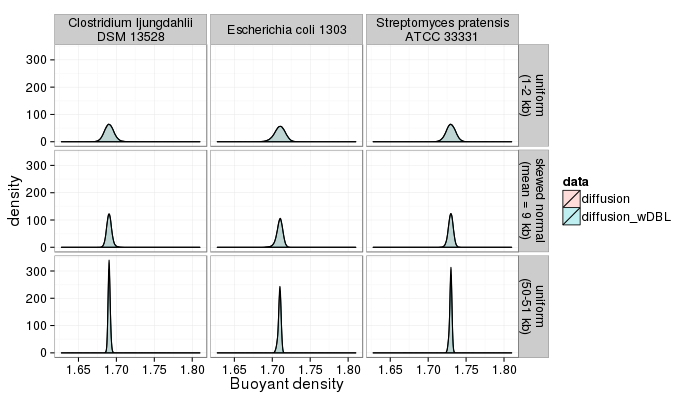

In [152]:
%%R -w 700 -h 400

tbl.f$fld = factor(tbl.f$fld, 
                   levels=c('uniform\n(1-2 kb)','skewed normal\n(mean = 9 kb)','uniform\n(50-51 kb)'))


ggplot(tbl.f, aes(BD, fill=data)) +
    geom_density(alpha=0.25) +
    facet_grid(fld ~ taxon_name) +
    theme_bw() +
    labs(x = 'Buoyant density') +
    theme(
        text=element_text(size=16),
        axis.title.y = element_text(vjust=1)
        )

## Determining the probability of detecting in all fragments

### skewed normal distribution

In [153]:
BD_vals = np.arange(min_BD, max_BD, 0.001)

In [154]:
F = os.path.join(workDir, 'ampFrags_real_kde_dif_DBL.pkl')
with open(F, 'rb') as inFH:
    kde = dill.load(inFH)
kde

{'Clostridium_ljungdahlii_DSM_13528': <scipy.stats.kde.gaussian_kde at 0x7f226b237a50>,
 'Escherichia_coli_1303': <scipy.stats.kde.gaussian_kde at 0x7f226b2375d0>,
 'Streptomyces_pratensis_ATCC_33331': <scipy.stats.kde.gaussian_kde at 0x7f226b237090>}

In [155]:
# probability at each location in gradient
pdf = {}
for k,v in kde.items():
    pdf[k] = v.evaluate(BD_vals)
pdf.keys()

['Clostridium_ljungdahlii_DSM_13528',
 'Escherichia_coli_1303',
 'Streptomyces_pratensis_ATCC_33331']

In [156]:
df = pd.DataFrame(pdf)
df['BD'] = BD_vals
df.head(n=3)

,Clostridium_ljungdahlii_DSM_13528,Escherichia_coli_1303,Streptomyces_pratensis_ATCC_33331,BD
0,0.111499,0.089763,0.071833,1.67323
1,0.146687,0.067412,0.060917,1.67423
2,0.169035,0.067115,0.080657,1.67523


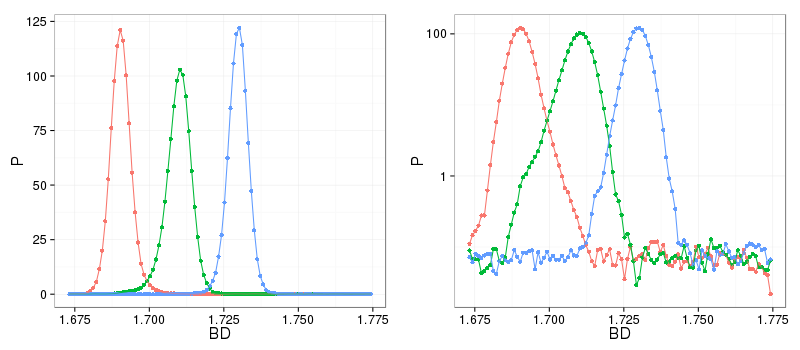

In [157]:
%%R -i df -w 800 -h 350

df.g = apply(df, 2, as.numeric) %>% as.data.frame %>%
    gather(taxon_name, P, 1:3) %>%
    mutate(BD = as.numeric(BD),
           P = as.numeric(P),
           taxon_name = as.character(taxon_name)) %>%
    filter(P > 1e-9)

p1 = ggplot(df.g, aes(BD, P, color=taxon_name)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'none'
    )

p2 = p1 + scale_y_log10()

grid.arrange(p1, p2, ncol=2)

#### Notes

* Even if 1% of DNA is in DBL (that then diffuses back into the gradient), the probably of detecting a taxa in at least most gradients is pretty high (relative to just diffusion)

### small fragment size distribution

In [158]:
BD_vals = np.arange(min_BD, max_BD, 0.001)

In [159]:
F = os.path.join(workDir, 'ampFrags_sm_kde_dif_DBL.pkl')
with open(F, 'rb') as inFH:
    kde = dill.load(inFH)
kde

{'Clostridium_ljungdahlii_DSM_13528': <scipy.stats.kde.gaussian_kde at 0x7f226b20ea50>,
 'Escherichia_coli_1303': <scipy.stats.kde.gaussian_kde at 0x7f226b20ea90>,
 'Streptomyces_pratensis_ATCC_33331': <scipy.stats.kde.gaussian_kde at 0x7f226b20ec10>}

In [160]:
# probability at each location in gradient
pdf = {}
for k,v in kde.items():
    pdf[k] = v.evaluate(BD_vals)
pdf.keys()

['Clostridium_ljungdahlii_DSM_13528',
 'Escherichia_coli_1303',
 'Streptomyces_pratensis_ATCC_33331']

In [161]:
df = pd.DataFrame(pdf)
df['BD'] = BD_vals
df.head(n=3)

,Clostridium_ljungdahlii_DSM_13528,Escherichia_coli_1303,Streptomyces_pratensis_ATCC_33331,BD
0,1.725685,0.088851,0.071739,1.67323
1,2.285557,0.082760,0.072885,1.67423
2,3.333377,0.072099,0.080033,1.67523


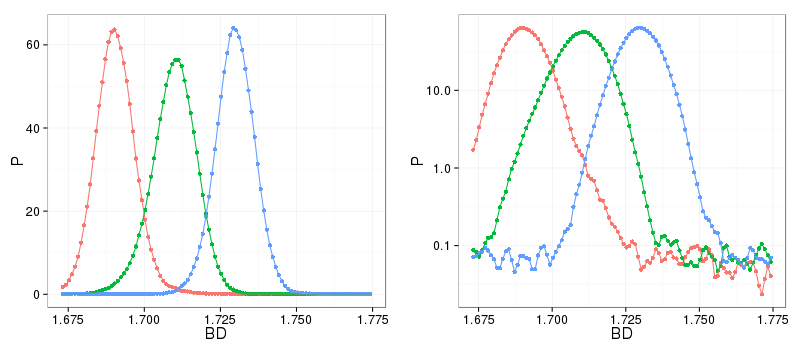

In [162]:
%%R -i df -w 800 -h 350

df.g = apply(df, 2, as.numeric) %>% as.data.frame %>%
    gather(taxon_name, P, 1:3) %>%
    mutate(BD = as.numeric(BD),
           P = as.numeric(P),
           taxon_name = as.character(taxon_name)) %>%
    filter(P > 1e-9)

p1 = ggplot(df.g, aes(BD, P, color=taxon_name)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'none'
    )

p2 = p1 + scale_y_log10()

grid.arrange(p1, p2, ncol=2)

#### Notes

* Even with a small fragment size and a DBL, the taxa are not necessarily going to be present in all gradient fractions.